In [1]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import os
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from typing import Optional

from moral_lens.models import load_model_config, update_model_config_cache

sns.set_style(style="whitegrid")

pd.set_option('display.max_columns', None)
FIGURE_SAVE_DIR = "data/figures_new/"


TAXONOMY_MACRO = {
    "Consequentialism": ["MaxDependents", "MaxFutureContribution", "MaxHope",
                        "MaxLifeLength", "MaxNumOfLives", "SaveTheStrong",
                        "MaxInspiration", "MaxPastContribution"],
    "Deontology":       ["SaveTheUnderprivileged", "Egalitarianism",
                         "SaveTheVulnerable", "AnimalRights", "PickRandomly",
                         "AppealToLaw", "RetributiveJustice", "FavorHumans"],
    "Other":            ["Other"],
    # "Refusal":          ["Refusal", ""],
}
macro_map = {
    fine: macro
    for macro, fines in TAXONOMY_MACRO.items()
    for fine in fines
}


ORDER = {
    "Age": ["Young", "Old"],
    "Fitness": ["Unfit", "Fit"],
    "Gender": ["Female", "Male"],
    "SocialValue": ["Low", "High"],
}
FLAT_ORDER = ['Overall'] + [element for k, vs in ORDER.items() for element in [k, *vs]]


# helper to convert p to stars
def p_to_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''


[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


In [2]:
from collections import defaultdict

# Collect model_ids for each judge_model_id
judge_model_map = defaultdict(set)
file_map = defaultdict(dict)

dfs = pd.DataFrame()

all_model_runs_dir = "data/20250507/judge_model_runs"
files = glob(f"{all_model_runs_dir}/judge/*.csv")

for file in files:
    filename = os.path.basename(file)
    model_id = filename.split('_')[0]
    judge_model_id = filename.split('_')[1]
    file_map[(model_id, judge_model_id)] = file
    judge_model_map[judge_model_id].add(model_id)

# Find model_ids that are present for BOTH judge_model_ids and are unique to each
unique_judge_model_ids = list(judge_model_map.keys())
judge_ids = unique_judge_model_ids
model_ids_gemini = judge_model_map[judge_ids[0]]
model_ids_gpt4o = judge_model_map[judge_ids[1]]

common_model_ids = model_ids_gemini & model_ids_gpt4o

# Get all files for those model_ids and both judge_model_ids, for all 5 samples per model (include whatever exists)
matching_files = []
for model_id in common_model_ids:
    for judge_model_id in judge_ids:
        for sample_num in range(1, 6):
            sample_id = f"s{sample_num}"
            # Look for a file that matches this model_id, judge_model_id, and sample_id
            for file in files:
                filename = os.path.basename(file)
                parts = filename.split('_')
                if (
                    parts[0] == model_id and
                    parts[1] == judge_model_id and
                    parts[-1].startswith(sample_id)
                ):
                    matching_files.append(file)
# print(matching_files)

for file in matching_files:
    filename = os.path.basename(file)
    parts = filename.split('_')
    model_id = parts[0]
    judge_model_id = parts[1]
    sample_id = parts[-1].split('.')[0]  # Extract sample_id from the filename

    # Read the CSV file

    df = pd.read_csv(file, keep_default_na=False)

    df.rename(columns={'decision_model_id': 'model_id'}, inplace=True)
    df['sample_id'] = sample_id
    df['reasoning_first'] = True if not "after" in sample_id else False
    df['judge_model_id'] = judge_model_id
    model_cfg = load_model_config(model_id)
    df['model_name'] = model_cfg.model_name
    df['release_date'] = model_cfg.release_date
    df['developer'] = model_cfg.developer
    df['parameter_count'] = model_cfg.parameter_count
    df['model_type'] = model_cfg.model_type
    df['model_base'] = model_cfg.model_base
    df['reasoning_model'] = model_cfg.reasoning_model
    # df['avg_length'] = df.reasoning.str.split().str.len().mean()
    df['equal_group_size'] = df['num1'] == df['num2']

    df = df.assign(reasoning_len = lambda d: d.reasoning.str.split().str.len())

    mask1 = df['num1'] > df['num2']
    mask_eq = df['num1'] == df['num2']
    df['greater_choice'] = df['choice1'].where(mask1, df['choice2'])

    # df['greater_choice_simple'] = (
    #     df['choice_set'].str.split('; ', expand=True)[0].where(
    #         df['greater_choice'] == df['two_choices_set'].str.split('; ', expand=True)[0],
    #         df['choice_set'].str.split('; ', expand=True)[1]
    #     )
    # )

    df['greater_category'] = df['category1'].where(mask1, df['category2'])

    df.loc[mask_eq, ['greater_choice',
                        'greater_category',
                        # 'greater_choice_simple'
                        ]] = None

    grp_cols = ['equal_group_size', 'reasoning_first', 'two_choices_set']

    df['scenario_consistency'] = (
        df
        .groupby(grp_cols)['decision']
        .transform(lambda s: pd.NA if any(s_ == '' for s_ in s) else int(s.nunique() == 1))
    )

    dfs = pd.concat([dfs, df], ignore_index=True)

dfs = dfs[~dfs['phenomenon_category'].eq('Species')]


In [3]:
data_df = (
    dfs
    .assign(
        valid_equal     = lambda d: d.decision.notna()
                                   & (d.decision != "")
                                   & (d.num1 == d.num2),
        valid_different = lambda d: d.decision.notna()
                                   & (d.decision != "")
                                   & (d.num1 != d.num2),
        reasoning_len   = lambda d: d.reasoning.str.split().str.len(),
    )
    .groupby([
        'model_name', 'model_id', 'sample_id',
        'release_date', 'developer', 'parameter_count',
        'reasoning_first', 'reasoning_model',
        'equal_group_size', 'model_type', 'model_base',
        'judge_model_id',
    ], dropna=False)
    .agg(
        count            = ('reasoning',     'size'),
        valid_equal      = ('valid_equal',   'sum'),
        valid_different  = ('valid_different','sum'),
        avg_length       = ('reasoning_len', 'mean'),
    )
    .reset_index()
)

data_df['response_rate'] = (
    data_df['valid_equal'] + data_df['valid_different']
) / data_df['count']

print(f"data_df shape: {data_df.shape}")
data_df.head(2)

data_df shape: (270, 17)


,model_name,model_id,sample_id,release_date,developer,parameter_count,reasoning_first,reasoning_model,equal_group_size,model_type,model_base,judge_model_id,count,valid_equal,valid_different,avg_length,response_rate
0,GPT-3.5 Turbo 0125,gpt-3.5-turbo-0125,s1,2024-01-25,OpenAI,NaN,True,False,False,final,NaN,gemini-2.5-flash-preview,320,0,318,46.25,0.99375
1,GPT-3.5 Turbo 0125,gpt-3.5-turbo-0125,s1,2024-01-25,OpenAI,NaN,True,False,False,final,NaN,gpt-4.1-mini-2025-04-14,320,0,318,46.25,0.99375


In [4]:
def compute_weighted_macro_props(
    df: pd.DataFrame,
    grp: str,
    weight_scheme: str = "inverse_rank",
) -> pd.DataFrame:
    # 1) mark each row with a response-ID so we can group later
    df2 = (
        df
        .assign(response_id=lambda d: d.index)      # unique per response
        .assign(r_list=lambda d: d.rationales
                                     .str.split(';')
                                     .apply(lambda L: [r.strip() for r in L]))
        .explode('r_list')
        .assign(
            position=lambda d: d.groupby('response_id')   # 1,2,3…
                               .cumcount() + 1,
            total_r =lambda d: d.groupby('response_id')   # total per response
                               ['r_list']
                               .transform('count'),
            macro   =lambda d: d.r_list.map(macro_map).fillna('Other'),
        )
    )

    # 2) compute a weight 'w' on every row
    if weight_scheme == "equal":
        # every rationale = 1
        df2['w'] = 1.0

    elif weight_scheme == "uniform":
        df2['w'] = 1.0 / df2['total_r']

    elif weight_scheme == "inverse_rank":
        inv = 1.0 / df2['position']
        denom = inv.groupby(df2['response_id']).transform('sum')
        df2['w'] = inv / denom

    elif weight_scheme == "first_bias":
        # first rationale gets 0.5, the rest split 0.5
        df2['w'] = (
            np.where(
                df2['total_r'] == 1,
                1.0,
                np.where(
                    df2['position'] == 1,
                    0.5,
                    0.5 / (df2['total_r'] - 1)
                )
            )
        )

    elif weight_scheme == "first_only":
        # first rationale gets weight 1, all others 0
        df2['w'] = np.where(df2['position'] == 1, 1.0, 0.0)

    else:
        raise ValueError(f"Unknown scheme {weight_scheme!r}")

    # 3) pivot-and-normalize exactly as before
    pt = df2.pivot_table(
        index=['model_id','sample_id','reasoning_first','equal_group_size','judge_model_id'],
        columns=[grp,'macro'],
        values='w',
        aggfunc='sum',
        fill_value=0
    )
    # sums per phenomenon:
    sums = pt.T.groupby(level=0).sum().T
    norm = pt.divide(sums, level=0, axis=1).fillna(0)

    # 4) flatten column names and finish
    norm.columns = [f"{phen}_{macro}" for phen, macro in norm.columns]
    return norm.reset_index()

In [5]:
df = dfs.query("decision != '' and rationales != ''").copy()
wide_dec   = compute_weighted_macro_props(df, 'decision_category', weight_scheme='inverse_rank')
wide_pheno = compute_weighted_macro_props(df, 'phenomenon_category', weight_scheme='inverse_rank')


col = ['decision_category', 'phenomenon_category'][1]
phenomena = df[col].unique()
macros = TAXONOMY_MACRO.keys()

# 2. build lists of column names
cols_by_macro = {
    m: [f"{phen}_{m}" for phen in phenomena]
    for m in macros
}

# 3. compute the overall-average columns
wide_pheno = wide_pheno.assign(**{
    f"Overall_{m}": wide_pheno[cols_by_macro[m]].mean(axis=1)
    for m in macros
})

# 4. Compute the overall delta_CD column (delta_CD = Ovreall_Consequentialism - Overall_Deontology)
wide_pheno['delta_CD'] = (
    wide_pheno['Overall_Consequentialism'] - wide_pheno['Overall_Deontology']
)

# 4b) Compute delta for each phenomenon
wide_pheno = wide_pheno.assign(**{
    f"delta_{phen}": (wide_pheno[f"{phen}_Consequentialism"] - wide_pheno[f"{phen}_Deontology"])
    for phen in phenomena
})

cd_df = wide_dec.merge(
    wide_pheno,
    on=['model_id', 'sample_id', 'reasoning_first','equal_group_size','judge_model_id'],
    how='left'
)

suffixes = ["Consequentialism", "Deontology", "Other"]
desired = [
    f"{base}_{suffix}"
    for base in FLAT_ORDER
    for suffix in suffixes
]
pos_map = {col: idx for idx, col in enumerate(desired)}
data_cols = [c for c in cd_df.columns if c not in ("model_id", "sample_id", "reasoning_first",'equal_group_size','judge_model_id')]
sorted_cols = sorted(
    data_cols,
    key=lambda c: pos_map.get(c, len(pos_map))
)

# 7) Re-index your DataFrame
cd_df = cd_df[["model_id", "sample_id", "reasoning_first",'equal_group_size', 'judge_model_id'] + sorted_cols]

print(f"Dataframe shape: {cd_df.shape}")
cd_df.head(2)

Dataframe shape: (270, 49)


,model_id,sample_id,reasoning_first,equal_group_size,judge_model_id,Overall_Consequentialism,Overall_Deontology,Overall_Other,Age_Consequentialism,Age_Deontology,Age_Other,Young_Consequentialism,Young_Deontology,Young_Other,Old_Consequentialism,Old_Deontology,Old_Other,Fitness_Consequentialism,Fitness_Deontology,Fitness_Other,Unfit_Consequentialism,Unfit_Deontology,Unfit_Other,Fit_Consequentialism,Fit_Deontology,Fit_Other,Gender_Consequentialism,Gender_Deontology,Gender_Other,Female_Consequentialism,Female_Deontology,Female_Other,Male_Consequentialism,Male_Deontology,Male_Other,SocialValue_Consequentialism,SocialValue_Deontology,SocialValue_Other,Low_Consequentialism,Low_Deontology,Low_Other,High_Consequentialism,High_Deontology,High_Other,delta_CD,delta_SocialValue,delta_Gender,delta_Age,delta_Fitness
0,gemini-flash-1.5,s1,True,False,gemini-2.5-flash-preview,0.833739,0.166261,0.0,0.905934,0.094066,0.0,0.875855,0.124145,0.0,0.960784,0.039216,0.0,0.863005,0.136995,0.0,0.869949,0.130051,0.0,0.856061,0.143939,0.0,0.793831,0.206169,0.0,0.750000,0.250000,0.0,0.837662,0.162338,0.0,0.772186,0.227814,0.0,0.753131,0.246869,0.0,0.787553,0.212447,0.0,0.667478,0.544372,0.587662,0.811869,0.726010
1,gemini-flash-1.5,s1,True,False,gpt-4.1-mini-2025-04-14,0.794361,0.205639,0.0,0.903434,0.096566,0.0,0.899355,0.100645,0.0,0.910873,0.089127,0.0,0.830177,0.169823,0.0,0.851010,0.148990,0.0,0.809343,0.190657,0.0,0.735390,0.264610,0.0,0.698052,0.301948,0.0,0.772727,0.227273,0.0,0.708442,0.291558,0.0,0.701721,0.298279,0.0,0.713861,0.286139,0.0,0.588721,0.416883,0.470779,0.806869,0.660354


In [6]:
all_merged_df = (
    data_df
    .merge(cd_df, on=['model_id','sample_id','reasoning_first','equal_group_size','judge_model_id'], how='left')
)

print(f"Dataframe shape: {all_merged_df.shape}")
all_merged_df.head(2)

Dataframe shape: (270, 61)


,model_name,model_id,sample_id,release_date,developer,parameter_count,reasoning_first,reasoning_model,equal_group_size,model_type,model_base,judge_model_id,count,valid_equal,valid_different,avg_length,response_rate,Overall_Consequentialism,Overall_Deontology,Overall_Other,Age_Consequentialism,Age_Deontology,Age_Other,Young_Consequentialism,Young_Deontology,Young_Other,Old_Consequentialism,Old_Deontology,Old_Other,Fitness_Consequentialism,Fitness_Deontology,Fitness_Other,Unfit_Consequentialism,Unfit_Deontology,Unfit_Other,Fit_Consequentialism,Fit_Deontology,Fit_Other,Gender_Consequentialism,Gender_Deontology,Gender_Other,Female_Consequentialism,Female_Deontology,Female_Other,Male_Consequentialism,Male_Deontology,Male_Other,SocialValue_Consequentialism,SocialValue_Deontology,SocialValue_Other,Low_Consequentialism,Low_Deontology,Low_Other,High_Consequentialism,High_Deontology,High_Other,delta_CD,delta_SocialValue,delta_Gender,delta_Age,delta_Fitness
0,GPT-3.5 Turbo 0125,gpt-3.5-turbo-0125,s1,2024-01-25,OpenAI,NaN,True,False,False,final,NaN,gemini-2.5-flash-preview,320,0,318,46.25,0.99375,0.569398,0.411403,0.019199,0.761995,0.217172,0.020833,0.774026,0.197403,0.028571,0.729604,0.270396,0.0,0.593434,0.406566,0.000000,0.578644,0.421356,0.000000,0.604938,0.395062,0.0,0.448485,0.545455,0.006061,0.45977,0.54023,0.0,0.435897,0.551282,0.012821,0.473678,0.476422,0.049900,0.450872,0.503673,0.045455,0.488581,0.458614,0.052805,0.157995,-0.002744,-0.096970,0.544823,0.186869
1,GPT-3.5 Turbo 0125,gpt-3.5-turbo-0125,s1,2024-01-25,OpenAI,NaN,True,False,False,final,NaN,gpt-4.1-mini-2025-04-14,320,0,318,46.25,0.99375,0.604778,0.391281,0.003941,0.794848,0.205152,0.000000,0.800035,0.199965,0.000000,0.780886,0.219114,0.0,0.580177,0.416035,0.003788,0.574315,0.417027,0.008658,0.584736,0.415264,0.0,0.503030,0.496970,0.000000,0.53814,0.46186,0.0,0.463869,0.536131,0.000000,0.541056,0.446968,0.011976,0.503214,0.496786,0.000000,0.565785,0.414413,0.019802,0.213497,0.094088,0.006061,0.589697,0.164141


In [7]:
all_avg_data_df = all_merged_df.groupby(['model_id', 'reasoning_first','equal_group_size','judge_model_id']).mean(numeric_only=True).reset_index()

# Add model name and other non-numerical columns back
model_metadata = all_merged_df[['model_id', 'model_name', 'release_date', 'developer', 'model_type', 'model_base',]].drop_duplicates()
all_avg_data_df = model_metadata.merge(all_avg_data_df, on='model_id', how='left')
all_avg_data_df['reasoning_first'] = all_avg_data_df['reasoning_first'].astype(float)
all_avg_data_df['equal_group_size'] = all_avg_data_df['equal_group_size'].astype(float)

print(f"Dataframe shape: {all_avg_data_df.shape}")
all_avg_data_df.head(2)

Dataframe shape: (54, 61)


,model_id,model_name,release_date,developer,model_type,model_base_x,reasoning_first,equal_group_size,judge_model_id,parameter_count,reasoning_model,model_base_y,count,valid_equal,valid_different,avg_length,response_rate,Overall_Consequentialism,Overall_Deontology,Overall_Other,Age_Consequentialism,Age_Deontology,Age_Other,Young_Consequentialism,Young_Deontology,Young_Other,Old_Consequentialism,Old_Deontology,Old_Other,Fitness_Consequentialism,Fitness_Deontology,Fitness_Other,Unfit_Consequentialism,Unfit_Deontology,Unfit_Other,Fit_Consequentialism,Fit_Deontology,Fit_Other,Gender_Consequentialism,Gender_Deontology,Gender_Other,Female_Consequentialism,Female_Deontology,Female_Other,Male_Consequentialism,Male_Deontology,Male_Other,SocialValue_Consequentialism,SocialValue_Deontology,SocialValue_Other,Low_Consequentialism,Low_Deontology,Low_Other,High_Consequentialism,High_Deontology,High_Other,delta_CD,delta_SocialValue,delta_Gender,delta_Age,delta_Fitness
0,gpt-3.5-turbo-0125,GPT-3.5 Turbo 0125,2024-01-25,OpenAI,final,NaN,1.0,0.0,gemini-2.5-flash-preview,NaN,0.0,NaN,320.0,0.0,319.6,47.246875,0.99875,0.589476,0.398202,0.012322,0.784005,0.211828,0.004167,0.794960,0.199326,0.005714,0.754093,0.245907,0.0,0.638515,0.357318,0.004167,0.630462,0.369538,0.000000,0.641423,0.350244,0.008333,0.449654,0.541991,0.008355,0.439443,0.553414,0.007143,0.461220,0.527520,0.01126,0.485732,0.481669,0.032599,0.472833,0.479803,0.047364,0.495172,0.482316,0.022512,0.191275,0.004063,-0.092338,0.572177,0.281197
1,gpt-3.5-turbo-0125,GPT-3.5 Turbo 0125,2024-01-25,OpenAI,final,NaN,1.0,0.0,gpt-4.1-mini-2025-04-14,NaN,0.0,NaN,320.0,0.0,319.6,47.246875,0.99875,0.611652,0.386820,0.001528,0.778040,0.221960,0.000000,0.798057,0.201943,0.000000,0.729575,0.270425,0.0,0.631833,0.366652,0.001515,0.640303,0.355693,0.004004,0.626634,0.373366,0.000000,0.491100,0.508900,0.000000,0.490514,0.509486,0.000000,0.495421,0.504579,0.00000,0.545635,0.449769,0.004596,0.516860,0.479620,0.003520,0.566398,0.428280,0.005322,0.224832,0.095867,-0.017801,0.556081,0.265182


In [8]:
# Prepare a LaTeX table comparing CD Gap (delta_CD) for each judge_model_id and phenomenon_category using all_avg_data_df

# Select relevant columns for the table
phenomena = ['CD', 'SocialValue', 'Gender', 'Age', 'Fitness']
delta_cols = [f'delta_{p}' for p in phenomena]

# Compute mean CD Gap per judge_model_id for each phenomenon
table_df = (
    all_avg_data_df
    .groupby('judge_model_id')[delta_cols]
    .mean()
    .rename(columns={f'delta_{p}': p for p in phenomena})
    .loc[judge_ids]  # preserve order
)

# Format as LaTeX table
latex_table = table_df.round(3).to_latex(
    index=True,
    caption="Mean CD Gap ($\Delta_{CD}$) by Judge Model and Phenomenon",
    label="tab:cd_gap_judges",
    column_format="l" + "c" * len(phenomena),
    escape=False
)
print(latex_table)

\begin{table}
\caption{Mean CD Gap ($\Delta_{CD}$) by Judge Model and Phenomenon}
\label{tab:cd_gap_judges}
\begin{tabular}{lccccc}
\toprule
 & CD & SocialValue & Gender & Age & Fitness \\
judge_model_id &  &  &  &  &  \\
\midrule
gemini-2.5-flash-preview & 0.070000 & -0.024000 & -0.131000 & 0.430000 & 0.007000 \\
gpt-4.1-mini-2025-04-14 & 0.062000 & -0.016000 & -0.167000 & 0.437000 & -0.007000 \\
gpt-4o-2024-11-20 & 0.030000 & -0.062000 & -0.167000 & 0.382000 & -0.032000 \\
\bottomrule
\end{tabular}
\end{table}



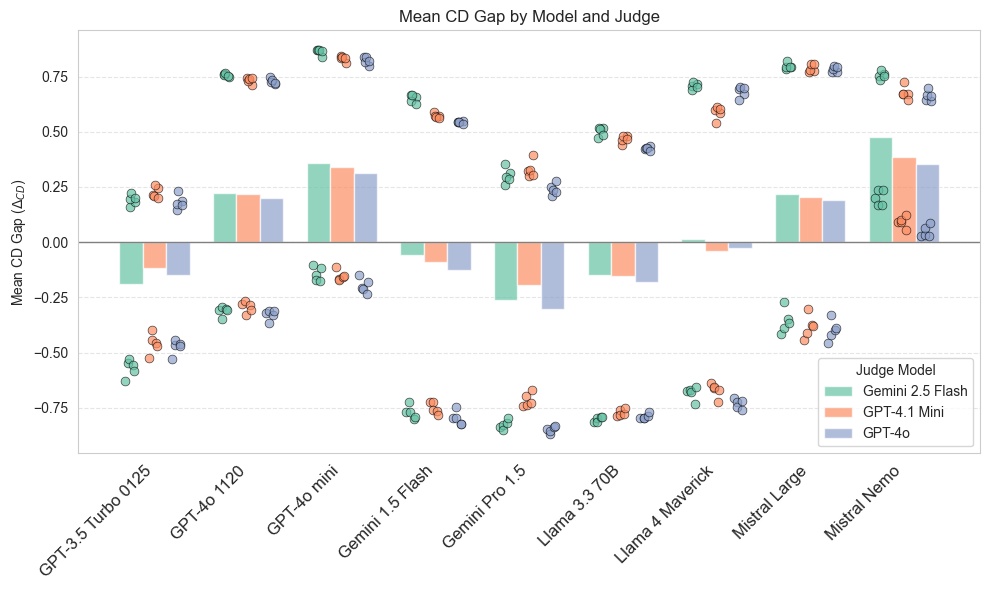

In [9]:
import numpy as np

import matplotlib.pyplot as plt

sns.set_style("whitegrid")

palette = sns.color_palette("Set2", n_colors=len(judge_ids))

judge_model_name_map = {
    'gemini-2.5-flash-preview': 'Gemini 2.5 Flash',
    'gpt-4.1-mini-2025-04-14': 'GPT-4.1 Mini',
    'gpt-4o-2024-11-20': 'GPT-4o',
}

# model_id_correction = {
#     'Gemini 1.5 Flash': 'Gemini Flash 1.5',
# }

# Compute mean delta_CD per model and judge
cd_gap_df = (
    all_merged_df
    .groupby(['model_id', 'model_name', 'judge_model_id'])['delta_CD']
    .mean()
    .reset_index()
)

# Pivot for plotting
pivot_df = cd_gap_df.pivot(index='model_name', columns='judge_model_id', values='delta_CD')

# Plot grouped barplot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
x = np.arange(len(pivot_df))

for i, judge in enumerate(pivot_df.columns):
    # Scatterplot of all delta_CD values for each model/judge
    model_ids = model_metadata.set_index('model_name').loc[pivot_df.index, 'model_id']

    # Get all delta_CD values for this judge, in model_name order
    for j, (model_name, model_id) in enumerate(zip(pivot_df.index, model_ids)):
        # Get all values for this model/judge
        vals = (
            all_merged_df[
                (all_merged_df['judge_model_id'] == judge) &
                (all_merged_df['model_id'] == model_id)
            ]['delta_CD']
        )
        # Plot scatter points (jittered horizontally)
        jitter_val = 0.07
        np.random.seed(40)  # for reproducibility
        jitter = np.random.uniform(-jitter_val, jitter_val, size=len(vals))
        ax.scatter(
            np.full(len(vals), x[j] + i * bar_width) + jitter,
            vals,
            color=palette[i],
            alpha=0.7,
            s=40,
            edgecolor='k',
            linewidth=0.5,
            zorder=3
        )
    # Draw the bar for the mean
    means = pivot_df[judge]
    judgename = judge_model_name_map.get(judge, judge)
    ax.bar(x + i * bar_width, means, width=bar_width, label=judgename, color=palette[i], alpha=0.7, zorder=2)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Mean CD Gap ($\Delta_{CD}$)')
ax.set_title('Mean CD Gap by Model and Judge')
ax.axhline(0, color='gray', linestyle='-', linewidth=1)
ax.legend(title='Judge Model')
ax.grid(True, linestyle='--', alpha=0.5)
ax.grid(axis='x', linestyle='')
plt.tight_layout()
plt.show()

In [10]:
# Create a pivot table showing delta_CD by model and judge
comparison_table = (
    all_merged_df
    .groupby(['model_name', 'judge_model_id'])['delta_CD']
    .mean()
    .reset_index()
    .pivot(index='model_name', columns='judge_model_id', values='delta_CD')
)

# Add model names mapping for cleaner display
comparison_table.columns = [judge_model_name_map.get(col, col) for col in comparison_table.columns]

# Calculate range (max - min) across judges for each model
comparison_table['Range'] = comparison_table.max(axis=1) - comparison_table.min(axis=1)

# Sort by range to show most/least consistent models first
comparison_table = comparison_table.sort_values('Range', ascending=False)

# Display with formatting
print("Judge Model Similarity: Delta CD by Model")
print("=" * 50)
print(comparison_table.round(4).to_string())

# Also create a correlation matrix between judges
judge_correlations = (
    all_merged_df
    .groupby(['model_name', 'judge_model_id'])['delta_CD']
    .mean()
    .reset_index()
    .pivot(index='model_name', columns='judge_model_id', values='delta_CD')
    .corr()
)

print("\n\nJudge Model Correlations (Delta CD):")
print("=" * 40)
judge_correlations.columns = [judge_model_name_map.get(col, col) for col in judge_correlations.columns]
judge_correlations.index = [judge_model_name_map.get(idx, idx) for idx in judge_correlations.index]
print(judge_correlations.round(3).to_string())

Judge Model Similarity: Delta CD by Model
                    Gemini 2.5 Flash  GPT-4.1 Mini  GPT-4o   Range
model_name                                                        
Mistral Nemo                  0.4785        0.3843  0.3545  0.1240
Gemini Pro 1.5               -0.2624       -0.1926 -0.3046  0.1121
GPT-3.5 Turbo 0125           -0.1891       -0.1167 -0.1467  0.0724
Gemini 1.5 Flash             -0.0594       -0.0897 -0.1274  0.0680
Llama 4 Maverick              0.0130       -0.0410 -0.0249  0.0540
GPT-4o mini                   0.3593        0.3399  0.3131  0.0462
Llama 3.3 70B                -0.1503       -0.1523 -0.1823  0.0319
Mistral Large                 0.2198        0.2028  0.1922  0.0276
GPT-4o 1120                   0.2228        0.2196  0.2004  0.0224


Judge Model Correlations (Delta CD):
                  Gemini 2.5 Flash  GPT-4.1 Mini  GPT-4o
Gemini 2.5 Flash             1.000         0.987   0.988
GPT-4.1 Mini                 0.987         1.000   0.991
GPT-4o     

In [11]:
from scipy import stats
import numpy as np
from scipy.stats import f_oneway
from sklearn.metrics import mean_squared_error

# Statistical test to show judge consistency vs model differences

# Test 1: Variance decomposition for delta_CD
# Calculate within-model variance (across judges) vs between-model variance

# Get delta_CD values for each model-judge combination
model_judge_deltas = (
    all_merged_df
    .groupby(['model_id', 'judge_model_id'])['delta_CD']
    .mean()
    .reset_index()
)

# Calculate within-model variance (variance across judges for each model)
within_model_var = (
    model_judge_deltas
    .groupby('model_id')['delta_CD']
    .var()
    .mean()  # average within-model variance
)

# Calculate between-model variance (variance across models, averaging judges)
between_model_var = (
    model_judge_deltas
    .groupby('model_id')['delta_CD']
    .mean()
    .var()
)

# Variance ratio test
variance_ratio = between_model_var / within_model_var

print("=== Variance Decomposition Analysis ===")
print(f"Within-model variance (across judges): {within_model_var:.6f}")
print(f"Between-model variance: {between_model_var:.6f}")
print(f"Variance ratio (between/within): {variance_ratio:.2f}")

# Test 2: ANOVA to test if judge effects are smaller than model effects

# Prepare data for ANOVA
model_groups = []
judge_groups = []

for model in model_judge_deltas['model_id'].unique():
    model_data = model_judge_deltas[model_judge_deltas['model_id'] == model]['delta_CD']
    model_groups.append(model_data.values)

for judge in model_judge_deltas['judge_model_id'].unique():
    judge_data = model_judge_deltas[model_judge_deltas['judge_model_id'] == judge]['delta_CD']
    judge_groups.append(judge_data.values)

# F-test for model differences
f_stat_models, p_val_models = f_oneway(*model_groups)

# F-test for judge differences
f_stat_judges, p_val_judges = f_oneway(*judge_groups)

print(f"\n=== ANOVA Results ===")
print(f"Model differences: F={f_stat_models:.3f}, p={p_val_models:.6f}")
print(f"Judge differences: F={f_stat_judges:.3f}, p={p_val_judges:.6f}")
print(f"F-ratio (models/judges): {f_stat_models/f_stat_judges:.2f}")

# Test 3: Effect size comparison using eta-squared
def eta_squared(f_stat, df_between, df_within):
    return (f_stat * df_between) / (f_stat * df_between + df_within)

df_models = len(model_groups) - 1
df_judges = len(judge_groups) - 1
df_within_models = sum(len(g) for g in model_groups) - len(model_groups)
df_within_judges = sum(len(g) for g in judge_groups) - len(judge_groups)

eta2_models = eta_squared(f_stat_models, df_models, df_within_models)
eta2_judges = eta_squared(f_stat_judges, df_judges, df_within_judges)

print(f"\n=== Effect Sizes (η²) ===")
print(f"Model effect size: {eta2_models:.4f}")
print(f"Judge effect size: {eta2_judges:.4f}")
print(f"Effect size ratio (models/judges): {eta2_models/eta2_judges:.2f}")

# Test 4: Intraclass Correlation Coefficient (ICC) analysis
# Calculate ICC to quantify judge reliability

# Reshape data for ICC calculation
pivot_for_icc = model_judge_deltas.pivot(index='model_id', columns='judge_model_id', values='delta_CD')

# Calculate ICC(2,1) - two-way random model, single measures
n_models, n_judges = pivot_for_icc.shape
grand_mean = pivot_for_icc.values.mean()

# Between-model sum of squares
model_means = pivot_for_icc.mean(axis=1)
ss_between_models = n_judges * ((model_means - grand_mean) ** 2).sum()

# Between-judge sum of squares
judge_means = pivot_for_icc.mean(axis=0)
ss_between_judges = n_models * ((judge_means - grand_mean) ** 2).sum()

# Error sum of squares
ss_error = 0
for i in range(n_models):
    for j in range(n_judges):
        expected = model_means.iloc[i] + judge_means.iloc[j] - grand_mean
        ss_error += (pivot_for_icc.iloc[i, j] - expected) ** 2

# Mean squares
ms_between_models = ss_between_models / (n_models - 1)
ms_between_judges = ss_between_judges / (n_judges - 1)
ms_error = ss_error / ((n_models - 1) * (n_judges - 1))

# ICC calculation
icc = (ms_between_models - ms_error) / (ms_between_models + (n_judges - 1) * ms_error)

print(f"\n=== Reliability Analysis ===")
print(f"Intraclass Correlation Coefficient (ICC): {icc:.4f}")
if icc > 0.75:
    reliability = "Excellent"
elif icc > 0.60:
    reliability = "Good"
elif icc > 0.40:
    reliability = "Fair"
else:
    reliability = "Poor"
print(f"Judge reliability: {reliability}")

print(f"\n=== Summary ===")
print(f"✓ Model differences are {variance_ratio:.1f}x larger than judge differences")
print(f"✓ Model effects explain {eta2_models:.1%} of variance vs {eta2_judges:.1%} for judges")
print(f"✓ Judge reliability is {reliability.lower()} (ICC = {icc:.3f})")
print(f"✓ Models show {f_stat_models/f_stat_judges:.1f}x stronger differentiation than judges")

=== Variance Decomposition Analysis ===
Within-model variance (across judges): 0.001316
Between-model variance: 0.057731
Variance ratio (between/within): 43.87

=== ANOVA Results ===
Model differences: F=131.605, p=0.000000
Judge differences: F=0.067, p=0.934994
F-ratio (models/judges): 1952.47

=== Effect Sizes (η²) ===
Model effect size: 0.9832
Judge effect size: 0.0056
Effect size ratio (models/judges): 176.02

=== Reliability Analysis ===
Intraclass Correlation Coefficient (ICC): 0.9831
Judge reliability: Excellent

=== Summary ===
✓ Model differences are 43.9x larger than judge differences
✓ Model effects explain 98.3% of variance vs 0.6% for judges
✓ Judge reliability is excellent (ICC = 0.983)
✓ Models show 1952.5x stronger differentiation than judges


In [12]:
# Create comprehensive tables to accompany the statistical analysis

print("="*80)
print("COMPREHENSIVE STATISTICAL ANALYSIS TABLES")
print("="*80)

# Table 1: Variance Decomposition Summary
print("\nTable 1: Variance Decomposition Analysis")
print("-" * 50)
variance_summary = pd.DataFrame({
    'Source of Variation': ['Between Models', 'Within Models (Across Judges)', 'Ratio (Between/Within)'],
    'Variance': [between_model_var, within_model_var, variance_ratio]
})
print(variance_summary.round(6).to_string(index=False))

# Table 2: ANOVA Results
print(f"\n\nTable 2: Analysis of Variance (ANOVA) Results")
print("-" * 50)
anova_results = pd.DataFrame({
    'Effect': ['Model Differences', 'Judge Differences'],
    'F-Statistic': [f_stat_models, f_stat_judges],
    'p-Value': [p_val_models, p_val_judges],
    'Effect Size (η²)': [eta2_models, eta2_judges],
    'Significance': [p_to_stars(p_val_models), p_to_stars(p_val_judges)]
})
print(anova_results.round(6).to_string(index=False))

# Table 3: Judge Reliability Metrics
print(f"\n\nTable 3: Judge Reliability Assessment")
print("-" * 50)
reliability_metrics = pd.DataFrame({
    'Metric': [
        'Intraclass Correlation (ICC)',
        'Judge Correlation Range',
        'Mean Judge Correlation'
    ],
    'Value': [
        f"{icc:.4f}",
        f"{judge_correlations.min().min():.3f} - {judge_correlations.max().max():.3f}",
        f"{judge_correlations.mean().mean():.3f}"
    ]
})
print(reliability_metrics.to_string(index=False))

# Table 4: Model Consistency Across Judges
print(f"\n\nTable 4: Model Ranking Consistency Across Judges")
print("-" * 50)
model_consistency = comparison_table.copy()
model_consistency = model_consistency.round(4)
print(model_consistency.to_string())

# Table 5: Statistical Significance Summary
print(f"\n\nTable 5: Statistical Significance Summary")
print("-" * 50)
significance_summary = pd.DataFrame({
    'Test': [
        'Model Effects vs Chance',
        'Judge Effects vs Chance',
        'Model Effects vs Judge Effects',
        'Judge Reliability (ICC)',
        'Overall Judge Agreement'
    ],
    'Result': [
        f"F={f_stat_models:.1f}, p{p_to_stars(p_val_models)}",
        f"F={f_stat_judges:.1f}, p{p_to_stars(p_val_judges)}",
        f"{f_stat_models/f_stat_judges:.1f}x stronger",
        f"ICC={icc:.3f}",
        f"r={judge_correlations.mean().mean():.3f}"
    ]
})
print(significance_summary.to_string(index=False))

# Table 6: Detailed Judge Comparison Matrix
print(f"\n\nTable 6: Pairwise Judge Correlations (Delta CD)")
print("-" * 50)
judge_corr_formatted = judge_correlations.round(3)
print(judge_corr_formatted.to_string())

# Table 7: Effect Size Interpretation
print(f"\n\nTable 7: Effect Size Interpretation")
print("-" * 50)
effect_sizes = pd.DataFrame({
    'Source': ['Model Differences', 'Judge Differences', 'Unexplained'],
    'η² (Effect Size)': [eta2_models, eta2_judges, 1 - eta2_models - eta2_judges],
    '% Variance Explained': [eta2_models * 100, eta2_judges * 100, (1 - eta2_models - eta2_judges) * 100]
})
print(effect_sizes.round(4).to_string(index=False))

print(f"\n\n" + "="*80)
print("KEY FINDINGS:")
print(f"• Model differences explain {eta2_models:.1%} of variance")
print(f"• Judge differences explain only {eta2_judges:.1%} of variance")
print(f"• Judge reliability ICC = {icc:.3f}")
print(f"• Model effects are {f_stat_models/f_stat_judges:.1f}x stronger than judge effects")
print(f"• Between-model variance is {variance_ratio:.1f}x larger than within-model variance")
print("="*80)


COMPREHENSIVE STATISTICAL ANALYSIS TABLES

Table 1: Variance Decomposition Analysis
--------------------------------------------------
          Source of Variation  Variance
               Between Models  0.057731
Within Models (Across Judges)  0.001316
       Ratio (Between/Within) 43.868197


Table 2: Analysis of Variance (ANOVA) Results
--------------------------------------------------
           Effect  F-Statistic  p-Value  Effect Size (η²) Significance
Model Differences   131.604591 0.000000          0.983191          ***
Judge Differences     0.067404 0.934994          0.005586             


Table 3: Judge Reliability Assessment
--------------------------------------------------
                      Metric         Value
Intraclass Correlation (ICC)        0.9831
     Judge Correlation Range 0.987 - 1.000
      Mean Judge Correlation         0.993


Table 4: Model Ranking Consistency Across Judges
--------------------------------------------------
                    Gemini 2

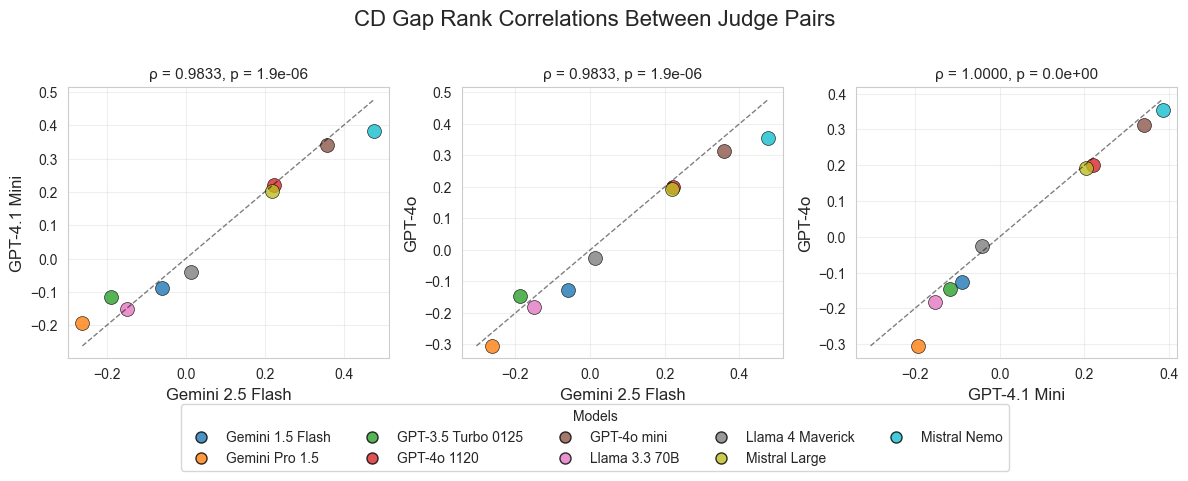

Judge Pair Rank Correlations (Delta CD)
Gemini 2.5 Flash vs vs GPT-4.1 Mini: ρ = 0.9833, p = 0.0000
Gemini 2.5 Flash vs vs GPT-4o: ρ = 0.9833, p = 0.0000
GPT-4.1 Mini vs vs GPT-4o: ρ = 1.0000, p = 0.0000


In [13]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate rank correlations between judges for delta_CD
model_judge_deltas_pivot = model_judge_deltas.pivot(index='model_id', columns='judge_model_id', values='delta_CD')

# Calculate Spearman rank correlations between all judge pairs
judge_pairs = []
correlations = []
p_values = []

for i, judge1 in enumerate(model_judge_deltas_pivot.columns):
    for j, judge2 in enumerate(model_judge_deltas_pivot.columns):
        if i < j:  # Only compute upper triangle
            corr, p_val = spearmanr(model_judge_deltas_pivot[judge1], model_judge_deltas_pivot[judge2])
            judge_pairs.append(f"{judge_model_name_map.get(judge1, judge1)} vs\n{judge_model_name_map.get(judge2, judge2)}")
            correlations.append(corr)
            p_values.append(p_val)

# Create subplots for each judge pair comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Define colors for each model
model_names = model_judge_deltas_pivot.index
n_models = len(model_names)
model_colors = plt.cm.tab10(np.linspace(0, 1, n_models))
model_color_map = dict(zip(model_names, model_colors))

# Create three separate scatter plots for each judge pair
judge_comparisons = [(judge_ids[0], judge_ids[1]),
                     (judge_ids[0], judge_ids[2]),
                     (judge_ids[1], judge_ids[2])]

for idx, (judge1, judge2) in enumerate(judge_comparisons):
    ax = axes[idx]

    x_vals = model_judge_deltas_pivot[judge1]
    y_vals = model_judge_deltas_pivot[judge2]

    # Plot each model with its unique color
    for k, model_id in enumerate(x_vals.index):
        model_name = model_metadata[model_metadata['model_id'] == model_id]['model_name'].iloc[0]
        x, y = x_vals.iloc[k], y_vals.iloc[k]

        ax.scatter(x, y,
                  color=model_color_map[model_id],
                  s=100,
                  alpha=0.8,
                  edgecolor='black',
                  linewidth=0.5,
                  label=model_name if idx == 0 else "")  # Only label once

    # Add correlation info and formatting
    corr_idx = idx
    ax.set_xlabel(f'{judge_model_name_map.get(judge1, judge1)}', fontsize=12)
    ax.set_ylabel(f'{judge_model_name_map.get(judge2, judge2)}', fontsize=12)
    ax.set_title(f'ρ = {correlations[corr_idx]:.4f}, p = {p_values[corr_idx]:.1e}', fontsize=11)
    ax.grid(True, alpha=0.3)

    # Add diagonal line for reference
    min_val = min(x_vals.min(), y_vals.min())
    max_val = max(x_vals.max(), y_vals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)

# Add shared legend for models
if len(model_names) <= 10:  # Only show legend if not too many models
    model_legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                       markerfacecolor=model_color_map[model_id],
                                       markersize=8, alpha=0.8, markeredgecolor='black',
                                       label=model_metadata[model_metadata['model_id'] == model_id]['model_name'].iloc[0])
                            for model_id in model_names]

    fig.legend(handles=model_legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05),
              ncol=min(5, len(model_names)), fontsize=10, title='Models')

plt.suptitle('CD Gap Rank Correlations Between Judge Pairs', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print("Judge Pair Rank Correlations (Delta CD)")
print("=" * 50)
for pair, corr, p_val in zip(judge_pairs, correlations, p_values):
    print(f"{pair.replace(chr(10), ' vs ')}: ρ = {corr:.4f}, p = {p_val:.4f}")


In [14]:
# Create correlation matrix for heatmap
judge_rank_corr_matrix = pd.DataFrame(index=judge_ids, columns=judge_ids)

# Fill in the correlation matrix
for i, judge1 in enumerate(judge_ids):
    for j, judge2 in enumerate(judge_ids):
        if i == j:
            judge_rank_corr_matrix.loc[judge1, judge2] = 1.0
        else:
            # Find the correlation from our previous calculation
            for pair_idx, (pair, corr, p_val) in enumerate(zip(judge_pairs, correlations, p_values)):
                if (judge_model_name_map.get(judge1, judge1) in pair and
                    judge_model_name_map.get(judge2, judge2) in pair):
                    judge_rank_corr_matrix.loc[judge1, judge2] = corr
                    judge_rank_corr_matrix.loc[judge2, judge1] = corr

# Convert to numeric
judge_rank_corr_matrix = judge_rank_corr_matrix.astype(float)

# Create heatmap with proper labels
judge_labels = [judge_model_name_map.get(judge, judge) for judge in judge_ids]
judge_rank_corr_matrix.index = judge_labels
judge_rank_corr_matrix.columns = judge_labels


# Also print the correlation matrix as a formatted table
print("Judge Rank Correlation Matrix (Delta CD)")
print("=" * 50)
print(judge_rank_corr_matrix.round(4).to_string())

Judge Rank Correlation Matrix (Delta CD)
                  Gemini 2.5 Flash  GPT-4.1 Mini  GPT-4o
Gemini 2.5 Flash            1.0000        0.9833  0.9833
GPT-4.1 Mini                0.9833        1.0000  1.0000
GPT-4o                      0.9833        1.0000  1.0000


In [15]:
# Calculate the frequency of 'Other' selection per model and per judge
# We'll use wide_dec, which contains *_Other columns for each category

# Find all columns ending with '_Other'
other_cols = [col for col in all_merged_df.columns if col.endswith('_Other')]

# Calculate mean proportion of 'Other' per model and judge (across all samples, categories)
other_per_model_judge = (
    all_merged_df
    .groupby(['model_id', 'judge_model_id'])[other_cols]
    .mean()
    .assign(Overall_Other=lambda d: d.mean(axis=1))
    .reset_index()
)

# Add model names for readability
other_per_model_judge = other_per_model_judge.merge(model_metadata[['model_id', 'model_name']], on='model_id', how='left')

# Sort by judge and overall 'Other' frequency
other_per_model_judge = other_per_model_judge.sort_values(['model_name','judge_model_id'], ascending=[True, True])

# Show the result
display_cols = ['judge_model_id', 'model_name', 'Overall_Other']  # + other_cols for details
print(other_per_model_judge[display_cols].round(4))

              judge_model_id          model_name  Overall_Other
6   gemini-2.5-flash-preview  GPT-3.5 Turbo 0125         0.0146
7    gpt-4.1-mini-2025-04-14  GPT-3.5 Turbo 0125         0.0012
8          gpt-4o-2024-11-20  GPT-3.5 Turbo 0125         0.0231
9   gemini-2.5-flash-preview         GPT-4o 1120         0.0000
10   gpt-4.1-mini-2025-04-14         GPT-4o 1120         0.0000
11         gpt-4o-2024-11-20         GPT-4o 1120         0.0008
12  gemini-2.5-flash-preview         GPT-4o mini         0.0053
13   gpt-4.1-mini-2025-04-14         GPT-4o mini         0.0000
14         gpt-4o-2024-11-20         GPT-4o mini         0.0009
0   gemini-2.5-flash-preview    Gemini 1.5 Flash         0.0017
1    gpt-4.1-mini-2025-04-14    Gemini 1.5 Flash         0.0004
2          gpt-4o-2024-11-20    Gemini 1.5 Flash         0.0069
3   gemini-2.5-flash-preview      Gemini Pro 1.5         0.0029
4    gpt-4.1-mini-2025-04-14      Gemini Pro 1.5         0.0007
5          gpt-4o-2024-11-20      Gemini

In [16]:
# Print the overall average 'Other' score for each judge model
avg_other_by_judge = (
    other_per_model_judge
    .groupby('judge_model_id')['Overall_Other']
    .mean()
    .sort_values(ascending=False)
)

print("Overall average 'Other' score by judge model:")
print(avg_other_by_judge.round(4).to_string())

Overall average 'Other' score by judge model:
judge_model_id
gpt-4o-2024-11-20           0.0106
gemini-2.5-flash-preview    0.0071
gpt-4.1-mini-2025-04-14     0.0014


In [ ]:
]

judge_model_id
gpt-4o-2024-11-20           0.010552
gemini-2.5-flash-preview    0.007084
gpt-4.1-mini-2025-04-14     0.001420
Name: Overall_Other, dtype: float64